In [5]:
import seaborn as sns
import pandas as pd
import time
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import yfinance as yf
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# DATA CLEANING

In [6]:
#read csv_data
df= yf.download('MARUTI.NS', start="2016-01-01", end="2025-01-01")
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)
df.head(10)


C:\Users\mithun\AppData\Local\Temp\ipykernel_13128\530479233.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df= yf.download('MARUTI.NS', start="2016-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2016-01-01,4280.914062,4308.139882,4247.550987,4264.763152,243597
1,2016-01-04,4227.523438,4297.987637,4219.309637,4277.683637,405501
2,2016-01-05,4214.879395,4246.073538,4205.926997,4245.335391,509285
3,2016-01-06,4135.370605,4238.921179,4123.557550,4237.998270,593742
4,2016-01-07,3938.883789,4106.668939,3924.071278,4106.668939,1200069
5,2016-01-08,3889.831787,3991.582533,3872.342476,3955.865764,994652
6,2016-01-11,3943.036865,3968.509247,3799.616877,3866.989243,865799
7,2016-01-12,3939.898682,3991.396826,3931.592500,3977.737952,481142
8,2016-01-13,3960.433350,3977.737894,3895.922099,3966.662986,431206
9,2016-01-14,3920.748535,3958.357081,3887.939297,3912.211626,402026


In [7]:
df.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2221 non-null   datetime64[ns]
 1   Close   2221 non-null   float64       
 2   High    2221 non-null   float64       
 3   Low     2221 non-null   float64       
 4   Open    2221 non-null   float64       
 5   Volume  2221 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 104.2 KB


In [8]:
df.describe()

Price,Date,Close,High,Low,Open,Volume
count,2221,2221.000000,2221.000000,2221.000000,2221.000000,2.221000e+03
mean,2020-07-01 16:05:24.178297856,7549.277941,7634.742980,7468.005026,7556.440769,7.494948e+05
min,2016-01-01 00:00:00,2986.995605,3170.146890,2947.079783,2954.139387,3.005200e+04
25%,2018-04-03 00:00:00,6360.875488,6452.372079,6297.063857,6373.809298,4.241570e+05
50%,2020-07-08 00:00:00,7217.062500,7310.315641,7125.501780,7215.887759,6.035070e+05
75%,2022-09-28 00:00:00,8628.583984,8709.010436,8560.244004,8636.974316,9.210900e+05
max,2024-12-31 00:00:00,13495.599609,13551.996884,13274.450195,13383.000000,4.892962e+06
std,NaN,2169.642927,2185.265975,2154.428760,2172.438408,4.976285e+05


In [6]:
df.drop_duplicates()

Price,Date,Close,High,Low,Open,Volume
0,2016-01-01,4280.914062,4308.139882,4247.550987,4264.763152,243597
1,2016-01-04,4227.523438,4297.987637,4219.309637,4277.683637,405501
2,2016-01-05,4214.879883,4246.074030,4205.927484,4245.335883,509285
3,2016-01-06,4135.370605,4238.921179,4123.557550,4237.998270,593742
4,2016-01-07,3938.884033,4106.669194,3924.071521,4106.669194,1200069
...,...,...,...,...,...,...
2216,2024-12-24,10736.599609,10887.450195,10725.000000,10822.000000,151149
2217,2024-12-26,10896.000000,10974.799805,10770.000000,10770.500000,349811
2218,2024-12-27,10941.049805,11133.000000,10912.599609,10929.500000,257973
2219,2024-12-30,10798.950195,10950.000000,10750.099609,10941.049805,335481


In [7]:
df.isnull().sum()

Price
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [8]:
# calculating z score
z_scores=np.abs(stats.zscore(df['Close'])) 
outliers = df[z_scores > 3]
print(outliers)


Empty DataFrame
Columns: [Date, Close, High, Low, Open, Volume]
Index: []


In [9]:

# calculating IOR
Q1=df["Close"].quantile(0.25)
Q3=df["Close"].quantile(0.75)
IQR=Q3-Q1
lower_limit=Q1-1.5*IQR
upper_limit=Q3+1.5*IQR


In [10]:
df[(df["Close"]<lower_limit )| (df["Close"]> upper_limit)]

Price,Date,Close,High,Low,Open,Volume
2031,2024-03-22,12222.256836,12311.018065,11778.795092,11778.795092,1062263
2032,2024-03-26,12135.921875,12206.604836,12027.595446,12170.594381,507568
2033,2024-03-27,12393.291016,12603.654650,12170.743633,12175.003204,878986
2034,2024-03-28,12482.448242,12607.715244,12269.608979,12452.333275,860324
2035,2024-04-01,12451.986328,12570.269494,12389.130801,12495.326961,314676
...,...,...,...,...,...,...
2168,2024-10-15,12446.750000,12709.000000,12355.000000,12709.000000,532135
2169,2024-10-16,12383.900391,12454.950195,12231.000000,12414.049805,418138
2170,2024-10-17,12143.750000,12420.099609,12070.000000,12400.000000,875937
2171,2024-10-18,12105.099609,12141.250000,11844.450195,12070.000000,506871


# ANALYSIS

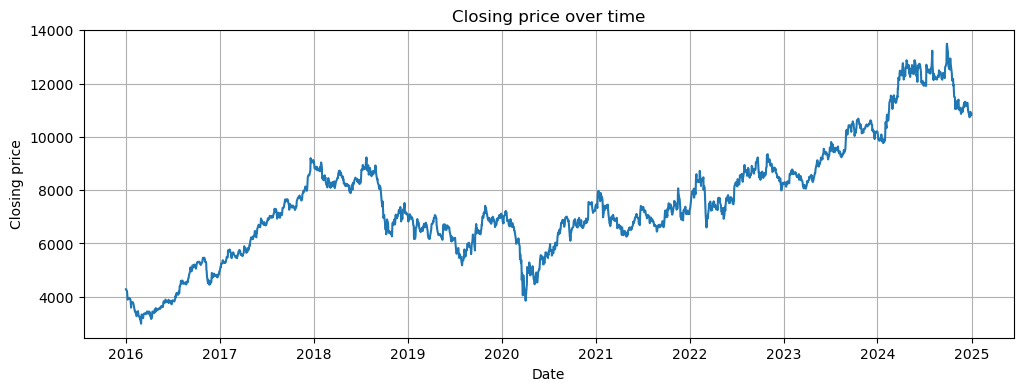

In [11]:
# ploting closing price of Reliance stock data about 8 years
plt.figure(figsize=(12,4))
plt.plot(df["Date"],df["Close"])
plt.title("Closing price over time")
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.grid(True)


#### stationary check

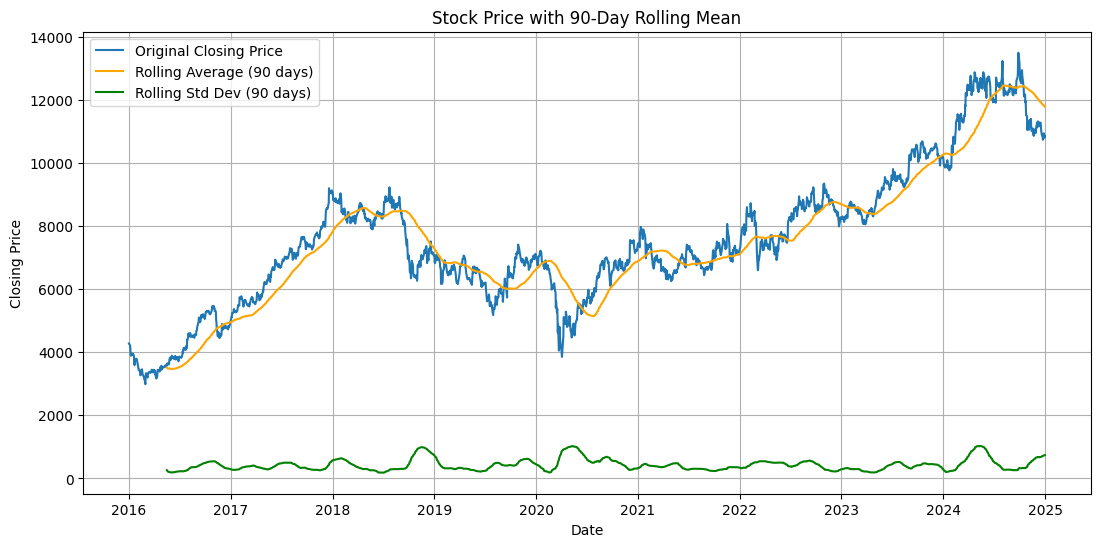

TEST STATISTICAL VALUES:

Test Statistic         -1.327424
p-value                 0.616534
Lags Used               0.000000
Observations Used    2220.000000
dtype: float64 

CRITICAL VALUES:

1%: -3.4332990438642623
5%: -2.8628427996988957
10%: -2.567463542934827


In [10]:

def test_statistic(dataframe, var):
    dataframe = dataframe.copy()  
    
    dataframe["rolling average"] = dataframe[var].rolling(window=90).mean()
    dataframe["rolling std deviation"] = dataframe[var].rolling(window=90).std()

    plt.figure(figsize=(13, 6))
    plt.plot(dataframe["Date"], dataframe[var], label='Original Closing Price')
    plt.plot(dataframe["Date"], dataframe["rolling average"], label='Rolling Average (90 days)', color='orange')
    plt.plot(dataframe["Date"], dataframe["rolling std deviation"], label='Rolling Std Dev (90 days)', color='green')
    
    plt.title('Stock Price with 90-Day Rolling Mean')
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # ADF test
    adTest = adfuller(dataframe[var].dropna(), autolag='AIC')
    stats = pd.Series(adTest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Observations Used'])
    
    print("TEST STATISTICAL VALUES:\n")
    print(stats, "\n")
    
    print("CRITICAL VALUES:\n")
    for key, value in adTest[4].items():
        print(f"{key}: {value}")

test_statistic(df,'Close')       

#### Convert the Data into Stationary :

   ##### time shift

In [11]:
data_df=df[["Date","Close"]].copy()


In [12]:
data_df["shift"]=data_df.Close.shift()
data_df["shiftdiff"]=data_df.Close - data_df["shift"]
print(data_df.columns)

Index(['Date', 'Close', 'shift', 'shiftdiff'], dtype='object', name='Price')


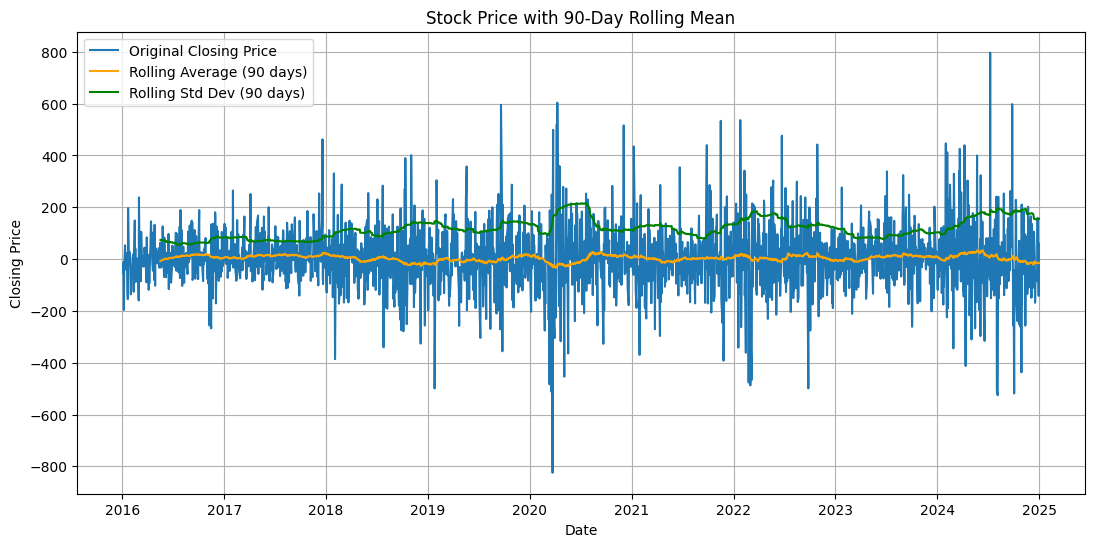

TEST STATISTICAL VALUES:

Test Statistic        -46.199892
p-value                 0.000000
Lags Used               0.000000
Observations Used    2219.000000
dtype: float64 

CRITICAL VALUES:

1%: -3.4333003744032
5%: -2.8628433872007037
10%: -2.5674638557393124


In [13]:
test_statistic(data_df.dropna(),'shiftdiff')

 # PACF / ACF

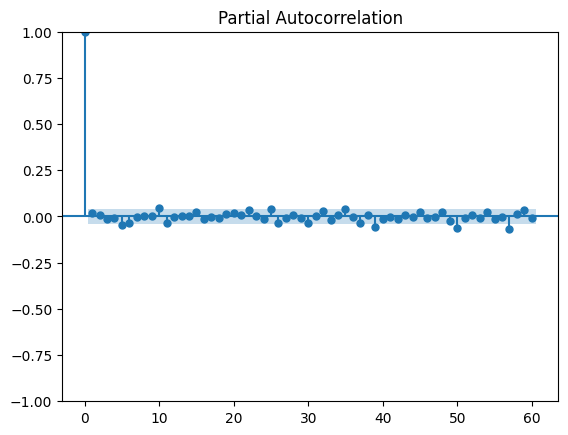

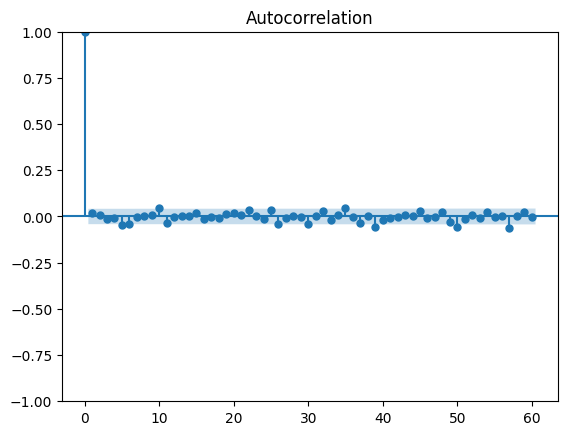

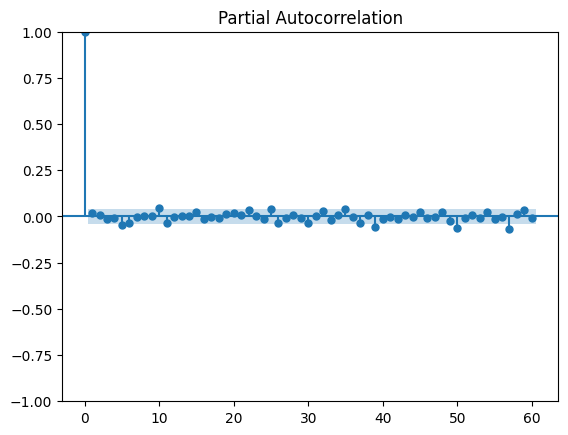

In [14]:

plot_acf(data_df["shiftdiff"].dropna(), lags=60)  
plot_pacf(data_df["shiftdiff"].dropna(), lags=60)




###### train and test

In [15]:

train=data_df[:round(len(data_df)*70/100)]
test=data_df[round(len(data_df)*70/100):]
train.head(10)

Price,Date,Close,shift,shiftdiff
0,2016-01-01,4280.914062,NaN,NaN
1,2016-01-04,4227.523438,4280.914062,-53.390625
2,2016-01-05,4214.879395,4227.523438,-12.644043
3,2016-01-06,4135.370605,4214.879395,-79.508789
4,2016-01-07,3938.883789,4135.370605,-196.486816
5,2016-01-08,3889.831787,3938.883789,-49.052002
6,2016-01-11,3943.036865,3889.831787,53.205078
7,2016-01-12,3939.898682,3943.036865,-3.138184
8,2016-01-13,3960.433350,3939.898682,20.534668
9,2016-01-14,3920.748535,3960.433350,-39.684814


In [16]:

test.head(10)

Price,Date,Close,shift,shiftdiff
1555,2022-04-21,7682.126953,7474.942383,207.184570
1556,2022-04-22,7706.793945,7682.126953,24.666992
1557,2022-04-25,7714.447754,7706.793945,7.653809
1558,2022-04-26,7708.988281,7714.447754,-5.459473
1559,2022-04-27,7593.598633,7708.988281,-115.389648
1560,2022-04-28,7690.853027,7593.598633,97.254395
1561,2022-04-29,7524.763672,7690.853027,-166.089355
1562,2022-05-02,7443.791504,7524.763672,-80.972168
1563,2022-05-04,7212.865723,7443.791504,-230.925781
1564,2022-05-05,7222.371582,7212.865723,9.505859


# ARIMA MODEL

In [17]:
auto_model = auto_arima(train["Close"], seasonal=False, trace=True, suppress_warnings=False)
best_order = auto_model.order
print("Best ARIMA order:", best_order)

# Fit ARIMA with best order
model = ARIMA(train["Close"], order=best_order)

model_fit=model.fit()
forecast = model_fit.predict(start=test.index[0], end=test.index[-1], typ="levels")
test = test.copy() 
test["arimapred"] = forecast.values


C:\Users\mithun\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finit

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19256.298, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19249.191, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19250.538, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19250.555, Time=0.08 sec


C:\Users\mithun\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19247.660, Time=0.03 sec


C:\Users\mithun\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19252.442, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.835 seconds
Best ARIMA order: (0, 1, 0)


C:\Users\mithun\anaconda3\envs\tf_env\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [21]:
test

Price,Date,Close,shift,shiftdiff,arimapred
1555,2022-04-21,7682.127441,7474.942383,207.185059,7474.942383
1556,2022-04-22,7706.793945,7682.127441,24.666504,7474.942383
1557,2022-04-25,7714.448242,7706.793945,7.654297,7474.942383
1558,2022-04-26,7708.987793,7714.448242,-5.460449,7474.942383
1559,2022-04-27,7593.598145,7708.987793,-115.389648,7474.942383
...,...,...,...,...,...
2216,2024-12-24,10736.599609,10822.000000,-85.400391,7474.942383
2217,2024-12-26,10896.000000,10736.599609,159.400391,7474.942383
2218,2024-12-27,10941.049805,10896.000000,45.049805,7474.942383
2219,2024-12-30,10798.950195,10941.049805,-142.099609,7474.942383


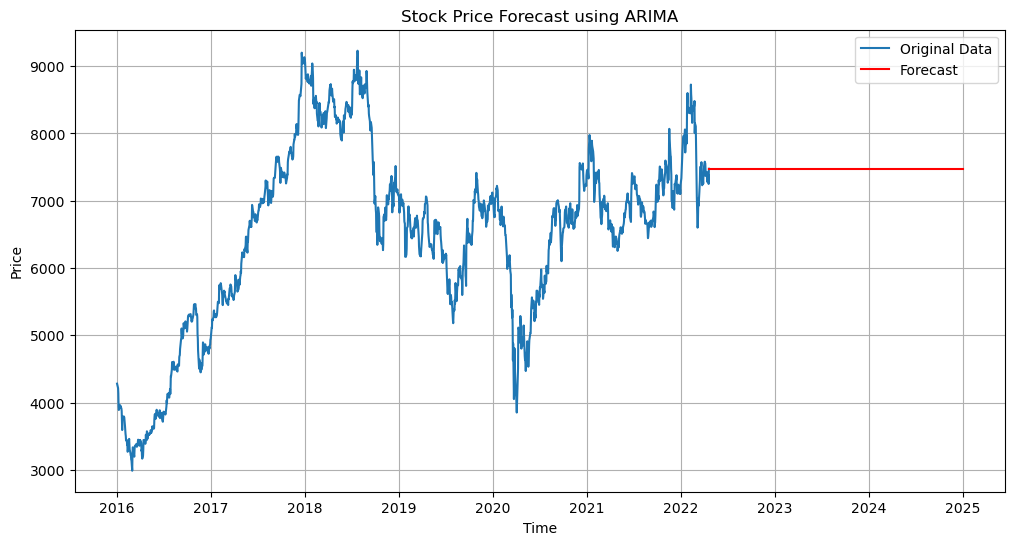

In [20]:
plt.figure(figsize=(12,6))

plt.plot(train['Date'],train["Close"], label='Original Data')
plt.plot(test["Date"],test["arimapred"], color='red', label='Forecast')

plt.title('Stock Price Forecast using ARIMA')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)


<Axes: xlabel='None', ylabel='Close'>

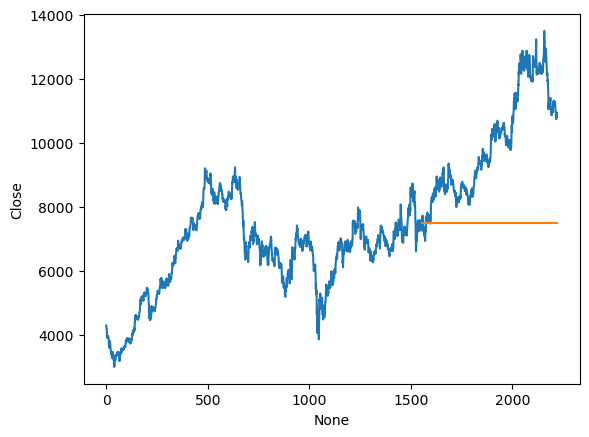

In [22]:
data_df.set_index('Date')
data_df["arimapred"]=forecast
data_df.dropna()
sns.lineplot(data=data_df,x=data_df.index,y='Close')
sns.lineplot(data=data_df,x=data_df.index,y='arimapred')

####  To find Error

In [23]:

np.sqrt(mean_squared_error(test['Close'],forecast))


np.float64(3007.1241094253905)

## SARIMA

In [31]:
data_df["diff12"]=df['Close'].diff(12)

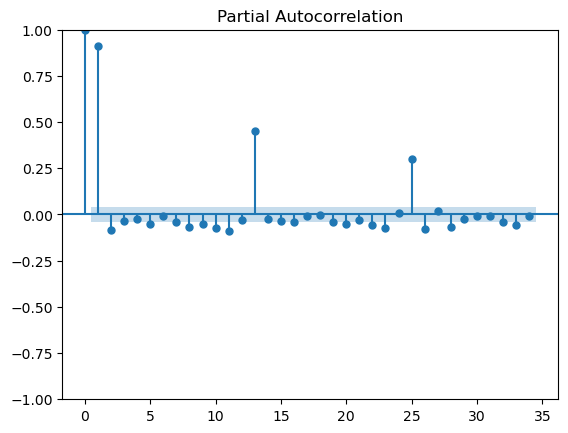

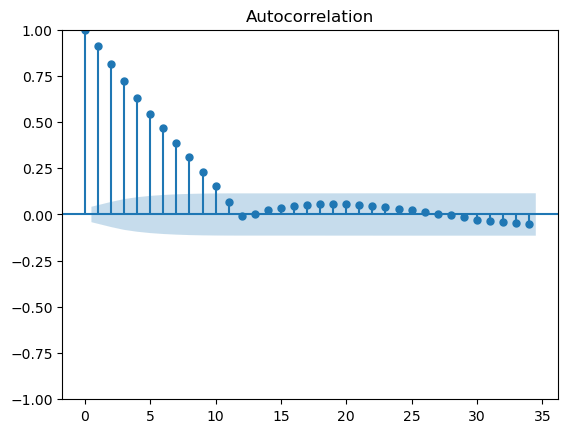

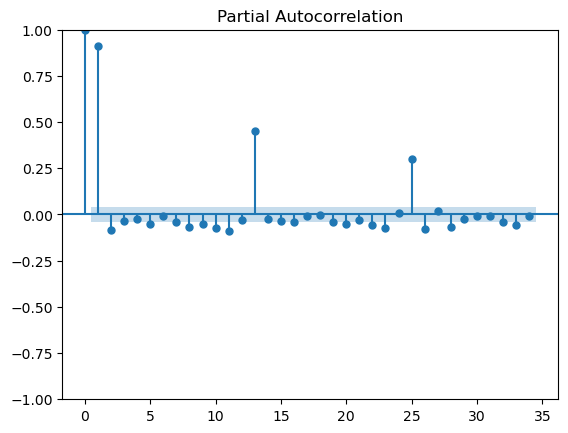

In [32]:
plot_acf(data_df['diff12'].dropna())
plot_pacf(data_df['diff12'].dropna())

In [24]:
auto_model = auto_arima(train["Close"],seasonal=True,m=12,stepwise=True,trace=True,suppress_warnings=True)
sarima_model = SARIMAX(train["Close"], 
                       order=auto_model.order, 
                       seasonal_order=auto_model.seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
model_fit=model.fit()
forecast=model_fit.predict(start=test.index[0],end=test.index[-1])
test["sarimapred"]=forecast

C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Us

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=19260.154, Time=2.01 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=19249.191, Time=0.03 sec


C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=19252.418, Time=0.27 sec


C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=19252.435, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=19247.661, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=19251.044, Time=0.16 sec


C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=19251.045, Time=0.23 sec


C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=19253.033, Time=1.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=19250.538, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=19250.555, Time=0.07 sec


C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\mithun\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=19252.442, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 4.477 seconds


<Axes: xlabel='None', ylabel='Close'>

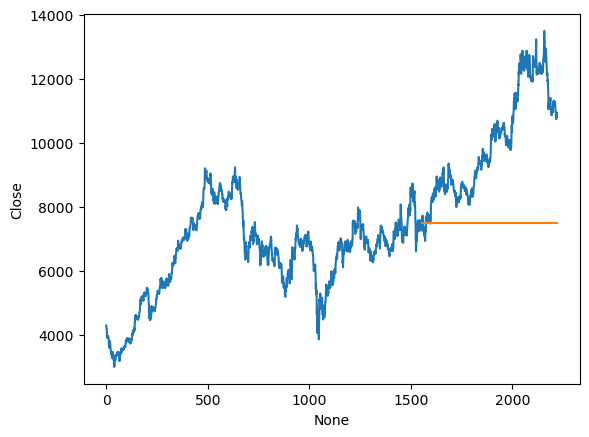

In [25]:

data_df["sarimapred"]=forecast
data_df.dropna()
sns.lineplot(data=data_df,x=data_df.index,y='Close')
sns.lineplot(data=data_df,x=data_df.index,y='sarimapred')

## PROPHET MODEL

18:37:52 - cmdstanpy - INFO - Chain [1] start processing
18:37:54 - cmdstanpy - INFO - Chain [1] done processing


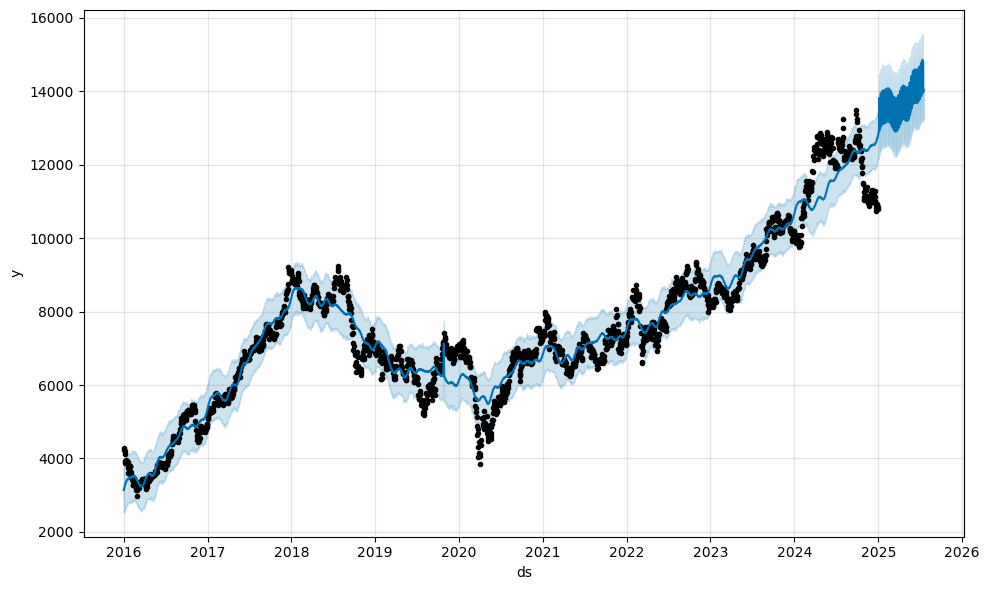

In [46]:
data2_df=df[["Date","Close"]].copy()
data2_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
model = Prophet()
model.fit(data2_df)

future = model.make_future_dataframe(periods=200)  
forecast = model.predict(future)
model.plot(forecast)
plt.show()



In [36]:
data2_df

Price,ds,y
0,2016-01-01,4280.914062
1,2016-01-04,4227.523926
2,2016-01-05,4214.880371
3,2016-01-06,4135.370605
4,2016-01-07,3938.883057
...,...,...
2216,2024-12-24,10736.599609
2217,2024-12-26,10896.000000
2218,2024-12-27,10941.049805
2219,2024-12-30,10798.950195


## LSTM MODEL

Epoch 1/10


C:\Users\mithun\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0285
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.7290e-04
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.4547e-04
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.6521e-04
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.5963e-04
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.7256e-04
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.5573e-04
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.6775e-04
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.4320e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step 


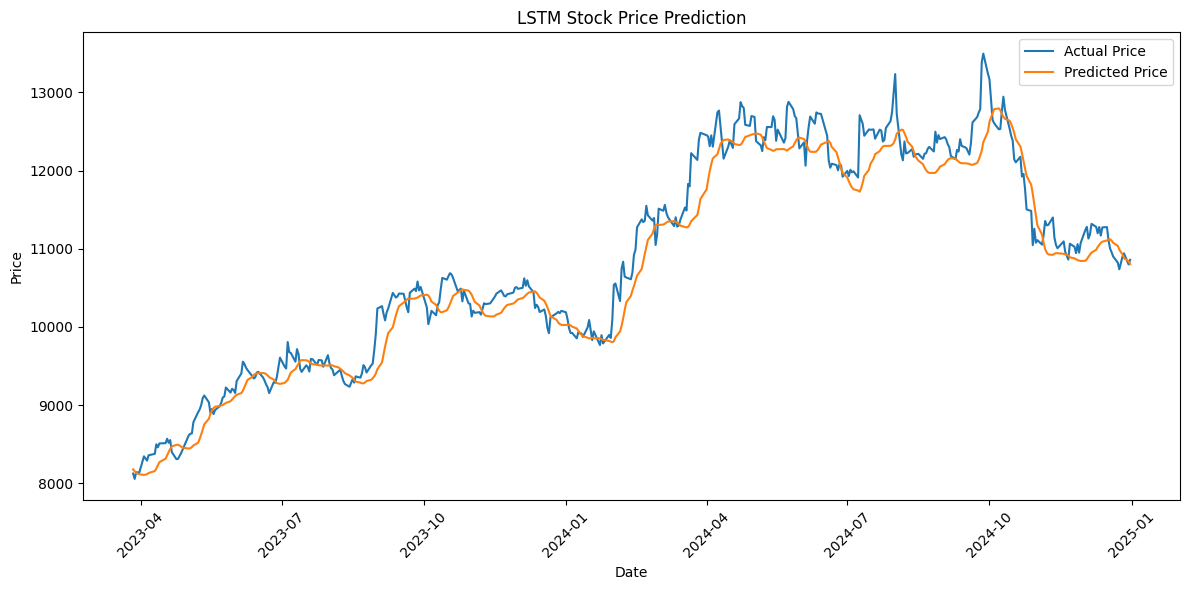

In [22]:

data3_df = df[['Close']]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data3_df)

def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)


y_pred = model.predict(X_test)

y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


dates = df['Date'].values[time_step:]
test_dates = dates[train_size:]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label='Actual Price')
plt.plot(test_dates, y_pred_actual, label='Predicted Price')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
